#### Separation, Position Angle, and Offset
- Great-circle separation *s* (arcsec) between WASP-168 and contaminate star.  
- Pair position angle (PA, degrees east of north).
- Projected distance between other star given the slit PA from the FITS header, slit width.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import interp1d

In [201]:
def wrap_deg_0_360(angle_deg: float) -> float:
    """
    Wrap an angle in degrees into the interval [0, 360).
    """
    return (angle_deg % 360.0 + 360.0) % 360.0

def great_circle_sep_and_pa(ra1_deg: float, dec1_deg: float,
                            ra2_deg: float, dec2_deg: float):
    """
    Compute great-circle separation and position angle (PA) from sky coordinates.

    This function takes two points on the celestial sphere, given by their right ascension (RA) and declination (Dec) in degrees, and returns:
      - the angular separation in arcseconds, and
      - the position angle (east of north) from point 1 to point 2, wrapped to [0, 360).

    Parameters
    ----------
    ra1_deg : float, Right ascension of point 1 in degrees (ICRS/J2000).
    dec1_deg : float, Declination of point 1 in degrees (ICRS/J2000).
    ra2_deg : float, Right ascension of point 2 in degrees (ICRS/J2000).
    dec2_deg : float, Declination of point 2 in degrees (ICRS/J2000).

    Returns
    -------
    separation_arcsec : float, Great-circle angular separation between the two points, in arcseconds.
    pa_pair_deg : float, Position angle from point 1 to point 2, measured east of north, in degrees, wrapped into [0, 360).

    Method
    ------
    - Separation:
      Use the haversine formulation for numerical robustness (especially at small separations):
          hav = sin^2(ΔDec/2) + cos(Dec1)*cos(Dec2)*sin^2(ΔRA/2)
          s_rad = 2*arcsin(sqrt(hav))  [radians]
      Then convert radians to arcseconds.

    - Position angle (east of north):
      Using the standard spherical trigonometry formula:
          y = sin(ΔRA)*cos(Dec2)
          x = cos(Dec1)*sin(Dec2) - sin(Dec1)*cos(Dec2)*cos(ΔRA)
          PA = atan2(y, x)  [radians]
      Convert to degrees and wrap into [0, 360).

    Notes
    -----
    All trigonometric operations use radians, hence the initial degree → radian conversion.
    """
    # Convert all input angles from degrees to radians for trig functions
    ra1, dec1 = np.deg2rad([ra1_deg, dec1_deg])
    ra2, dec2 = np.deg2rad([ra2_deg, dec2_deg])

    # Differences in RA and Dec (radians)
    dra  = ra2 - ra1
    ddec = dec2 - dec1

    # --- Great-circle separation via haversine formula (robust) ---
    # haversine of the angular distance:
    # hav(s) = sin^2(ddec/2) + cos(dec1)*cos(dec2)*sin^2(dra/2)
    hav = np.sin(ddec / 2.0)**2 + np.cos(dec1) * np.cos(dec2) * np.sin(dra / 2.0)**2

    # Angular separation in radians (s ∈ [0, π])
    s_rad = 2.0 * np.arcsin(np.sqrt(hav))

    # Convert radians to arcseconds with high precision
    ARCSEC_PER_RAD = 206264.80624709636 # 1 rad = 180/pi degrees; 1 degree = 3600 arcseconds.
    separation_arcsec = s_rad * ARCSEC_PER_RAD

    # --- Position angle (east of north) ---
    # Using the "y over x" form for atan2 ensures correct quadrant handling.
    y = np.sin(dra) * np.cos(dec2)
    x = np.cos(dec1) * np.sin(dec2) - np.sin(dec1) * np.cos(dec2) * np.cos(dra)

    # atan2 returns angle in radians in (-π, π]; convert to degrees and wrap to [0, 360)
    pa_rad = np.arctan2(y, x)
    pa_pair_deg = wrap_deg_0_360(np.rad2deg(pa_rad))

    return separation_arcsec, pa_pair_deg

def parallel_slit_offset(separation_arcsec: float,
                            pa_pair_deg: float,
                            pa_slit_deg: float) -> float:
    """
    Parallel distance to slit axis centred on target:
        d_parallel = s * |sin(PA_pair - PA_slit)|
    """
    dpa_rad = np.deg2rad(pa_pair_deg - pa_slit_deg)
    return abs(separation_arcsec * np.sin(dpa_rad))

def perpendicular_slit_offset(separation_arcsec: float,
                      pa_pair_deg: float,
                      pa_slit_deg: float) -> float:
    """
    Signed distance perpendicular to the slit axis:
        d_perpendicular = s * cos(PA_pair - PA_slit)
    Positive means 'in the +PA_slit direction' from the target.
    """
    dpa_rad = np.deg2rad(pa_pair_deg - pa_slit_deg)
    return separation_arcsec * np.cos(dpa_rad)

def ra_dec_offsets_arcsec(ra1_deg: float, dec1_deg: float,
                          ra2_deg: float, dec2_deg: float):
    """
    Small-angle RA/Dec component offsets from (ra1,dec1) → (ra2,dec2) in arcsec.
    +ΔRA = east, +ΔDec = north. Uses cos(dec_mid) scaling for RA.
    """
    dra_deg  = ra2_deg  - ra1_deg
    ddec_deg = dec2_deg - dec1_deg
    dec_mid_rad = np.deg2rad(0.5*(dec1_deg + dec2_deg))

    dRA_arcsec  = dra_deg  * 3600.0 * np.cos(dec_mid_rad)   # east-west component
    dDec_arcsec = ddec_deg * 3600.0                         # north-south component
    return dRA_arcsec, dDec_arcsec

#### Geometry Details
- Input coordinates of both star and slit information to get general information on their positions.

In [450]:
# from FITS header HIERARCH ESO ADA POSANG
PA_slit_deg = 46.87  
PA_slit_deg = 30.52766

# Gaia coordinates of target and other star
RA_target  = 96.74464273154
DEC_target = -46.8213635464
RA_other   = 96.74348904284
DEC_other  = -46.82372913421

# Gaia uncertainties 
e_RA_target_mas  = 0.0181
e_DE_target_mas  = 0.0202
e_RA_other_mas   = 0.0551
e_DE_other_mas   = 0.0611

# Quick check with Astropy for sanity
c1 = SkyCoord(ra=96.74464273154*u.deg, dec=-46.8213635464*u.deg)
c2 = SkyCoord(ra=96.74348904284*u.deg, dec=-46.82372913421*u.deg)
sep_astropy = c1.separation(c2)

# Compute geometry
sep_arcsec, pa_pair_deg = great_circle_sep_and_pa(RA_target, DEC_target,RA_other, DEC_other)
d_parallel_arcsec = parallel_slit_offset(sep_arcsec, pa_pair_deg, PA_slit_deg)
d_perp_arcsec  = perpendicular_slit_offset(sep_arcsec,  pa_pair_deg, PA_slit_deg)
# Component offsets in RA/Dec (signed; +RA=east, +Dec=north)
dRA_arcsec, dDec_arcsec = ra_dec_offsets_arcsec(RA_target, DEC_target, RA_other, DEC_other)

# Output
print("=== Geometry results ===")
print(f"Separation s                  : {sep_arcsec:9.5f} arcsec")
print(f"Separation s (Astropy check)  : {sep_astropy.to(u.arcsec).value:9.5f} arcsec")
#print(f"Pair PA (E of N)              : {pa_pair_deg:9.5f} deg")
#print(f"Slit PA (E of N)              : {PA_slit_deg:9.5f} deg")
print(f"d_perp  (⊥ to slit)           : {d_perp_arcsec:9.5f} arcsec")
print(f"d_parallel (along slit, ±)    : {d_parallel_arcsec:9.5f} arcsec")
print(f"ΔRA (east +)                  : {dRA_arcsec:9.5f} arcsec")
print(f"ΔDec (north +)                : {dDec_arcsec:9.5f} arcsec")

=== Geometry results ===
Separation s                  :   8.97779 arcsec
Separation s (Astropy check)  :   8.97779 arcsec
d_perp  (⊥ to slit)           :  -8.77920 arcsec
d_parallel (along slit, ±)    :   1.87787 arcsec
ΔRA (east +)                  :  -2.84192 arcsec
ΔDec (north +)                :  -8.51612 arcsec


#### Plotting stars and slit geometry

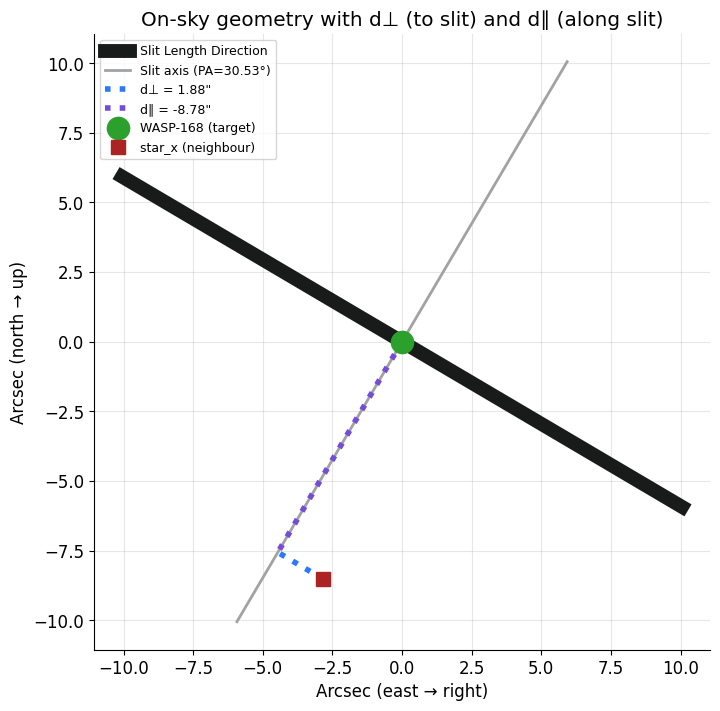

In [451]:
# Target at origin. Neighbour at (s, PA_pair). Slit axis at PA_slit.

fig, ax = plt.subplots(figsize=(8, 8))

# Convert to plotted coordinates (+y north, +x east)
# Polar → Cartesian: we place neighbour using separation and PA.
theta_pair = np.deg2rad(90.0 - pa_pair_deg)     # north-up convention
x_nb = sep_arcsec * np.cos(theta_pair)
y_nb = sep_arcsec * np.sin(theta_pair)

# Unit vectors for slit axis and its perpendicular (on the plot plane)
theta_slit = np.deg2rad(90.0 - PA_slit_deg)
u_slit  = np.array([np.cos(theta_slit),  np.sin(theta_slit)])            # along slit
u_perp  = np.array([-np.sin(theta_slit), np.cos(theta_slit)])            # ⟂ to slit

# Signed projections (should match printed values)
proj_parallel = x_nb*u_slit[0] + y_nb*u_slit[1]      # = d_parallel_arcsec (signed)
proj_perp     = x_nb*u_perp[0] + y_nb*u_perp[1]      # signed; abs() = d_perp_arcsec

x_par, y_par = proj_parallel*u_slit # Foot-of-perpendicular (projection point onto slit axis)
x_perp, y_perp = proj_perp*u_perp # Foot onto ⟂ axis (not strictly needed, but can be useful)

def line_points(theta, half_len):
    xs = np.array([-half_len, half_len]) * np.cos(theta)
    ys = np.array([-half_len, half_len]) * np.sin(theta)
    return xs, ys

L = max(10.0, 1.3*sep_arcsec)

# Draw slit axis and its perpendicular
xs, ys = line_points(theta_slit, L)
xp, yp = line_points(theta_slit + np.pi/2.0, L)
ax.plot(xp, yp, '-', lw=10, color="#191A1A" ,label="Slit Length Direction")
ax.plot(xs, ys, '-',  lw=2, color="#a1a2a3", label=f"Slit axis (PA={PA_slit_deg:.2f}°)")

# Annotate d_perp (to slit)
ax.plot([x_nb, x_par], [y_nb, y_par], ':', color="#2979ff",lw=4, label=f"d⊥ = {abs(proj_perp):.2f}\"")
# Annotate d_parallel (along slit from target to projection point)
ax.plot([0, x_par], [0, y_par], ':', color="#754cd6",lw=4, label=f"d∥ = {proj_parallel:.2f}\"")

# Target and neighbour
ax.plot(0, 0, 'o', ms=16, label="WASP-168 (target)",color="#2ca02c")
ax.plot(x_nb, y_nb, 's', ms=10, label="star_x (neighbour)",color="#ac2323")

ax.set_aspect('equal', 'box')
ax.set_xlabel('Arcsec (east → right)')
ax.set_ylabel('Arcsec (north → up)')
ax.set_title('On-sky geometry with d⊥ (to slit) and d∥ (along slit)')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=9)
plt.show()

#### Arcsecond to Pixels

In [452]:
# EFOSC2 CCD #40 constants (unbinned)
plate_scale_unbinned_arcsec_per_pix = 0.12    # arcsec/pix (both axes)
dispersion_unbinned_A_per_pix       = 2.04    # Å/pix for Grism #11 (quoted per unbinned pixel)
example_aperture_half_width_pixel = 22  # example half-width of extraction aperture in (binned) pixels

binx, biny = 2, 2  # from WIN1 BINX/BINY = 2 in your headers

plate_scale_arcsec_per_pix_x = plate_scale_unbinned_arcsec_per_pix * binx # along x on the detector
plate_scale_arcsec_per_pix_y = plate_scale_unbinned_arcsec_per_pix * biny # along y on the detector

# Effective dispersion per (binned) pixel along dispersion (EFOSC2 gr#11 disperses along y):
dispersion_A_per_pix         = dispersion_unbinned_A_per_pix * biny

print(f"Plate scale (x): {plate_scale_arcsec_per_pix_x:.3f} arcsec/pix")
print(f"Plate scale (y): {plate_scale_arcsec_per_pix_y:.3f} arcsec/pix")
print(f"Dispersion (Å per binned pixel): {dispersion_A_per_pix:.2f} Å/pix")

d_perp_pix     = d_perp_arcsec     / plate_scale_arcsec_per_pix_y
d_parallel_pix = d_parallel_arcsec / plate_scale_arcsec_per_pix_y

print("\n--- Offsets relative to slit ---")
print(f"d_perp      : {d_perp_arcsec:.3f} arcsec  ({d_perp_pix:.2f} pixels)")
print(f"d_parallel  : {d_parallel_arcsec:.3f} arcsec  ({d_parallel_pix:.2f} pixels, signed)")

print("\n--- Aperture Pixel Range to Arcsecs ---")
aperture_half_width_arcsec = example_aperture_half_width_pixel * plate_scale_arcsec_per_pix_y
print(f"Aperture half-width: {aperture_half_width_arcsec:.3f} arcsec  ({example_aperture_half_width_pixel:.2f} pixels)")

Plate scale (x): 0.240 arcsec/pix
Plate scale (y): 0.240 arcsec/pix
Dispersion (Å per binned pixel): 4.08 Å/pix

--- Offsets relative to slit ---
d_perp      : -8.779 arcsec  (-36.58 pixels)
d_parallel  : 1.878 arcsec  (7.82 pixels, signed)

--- Aperture Pixel Range to Arcsecs ---
Aperture half-width: 5.280 arcsec  (22.00 pixels)


#### Resolution (WIP)

In [397]:
lambda0 = 5893      # Å for Na D lines
dispersion = dispersion_A_per_pix  # Å/pix (binned)
plate_scale = plate_scale_arcsec_per_pix_x  # arcsec/pix
for slit in [1.0, 1.5, 2.0,27.0]:
    Npix = slit / plate_scale
    dlam = Npix * dispersion
    R = lambda0 / dlam
    print(f"Slit {slit:.1f}\" -> Δλ={dlam:5.2f} Å   R≈{R:5.0f}")
    print(f"  Suggested min bin width ≈ {2*dlam:5.1f} Å (~{2*Npix:4.1f} pixels)\n")

Slit 1.0" -> Δλ=17.00 Å   R≈  347
  Suggested min bin width ≈  34.0 Å (~ 8.3 pixels)

Slit 1.5" -> Δλ=25.50 Å   R≈  231
  Suggested min bin width ≈  51.0 Å (~12.5 pixels)

Slit 2.0" -> Δλ=34.00 Å   R≈  173
  Suggested min bin width ≈  68.0 Å (~16.7 pixels)

Slit 27.0" -> Δλ=459.00 Å   R≈   13
  Suggested min bin width ≈ 918.0 Å (~225.0 pixels)



#### Contamination: Fully captured flux from both stars
- Most basic calculation essentially just calculating the magnitude differences.

In [398]:
# Gaia magnitude differences (other − target)
deltaG  = 16.9294 - 11.7139 # Gaia G-band       
deltaBP = 17.4827 - 12.0150 # Gaia BP-band
deltaRP = 16.2098 - 11.2642 # Gaia RP-band

def flux_ratio(delta_mag):
    # f2/f1 = 10^(-0.4 Δm)
    return 10**(-0.4*delta_mag)
    
fG  = flux_ratio(deltaG)
fBP = flux_ratio(deltaBP)
fRP = flux_ratio(deltaRP)

print("Flux-ratio equation:")
print("   f_other / f_target = 10^(-0.4 * Δmag)")
print()
print(f"ΔG  = {deltaG:.4f} mag -> ratio = {fG:.6f}  (~{100*fG:.2f} %)")
print(f"ΔBP = {deltaBP:.4f} mag -> ratio = {fBP:.6f} (~{100*fBP:.2f} %)")
print(f"ΔRP = {deltaRP:.4f} mag -> ratio = {fRP:.6f} (~{100*fRP:.2f} %)")

Flux-ratio equation:
   f_other / f_target = 10^(-0.4 * Δmag)

ΔG  = 5.2155 mag -> ratio = 0.008200  (~0.82 %)
ΔBP = 5.4677 mag -> ratio = 0.006500 (~0.65 %)
ΔRP = 4.9456 mag -> ratio = 0.010514 (~1.05 %)


#### Moffat PSF, aperture throughput, and white-light contamination

- One step up from the prvious calculation, this is assuming not all of the flux was captured from both stars.
- Use astropy.modeling.models.Moffat1D to define the PSF shape. 
- The model's "gamma" is the core width and "alpha" is the power-law index. 
- Gamma from (FWHM, alpha) via the standard relation and normalize the profile numerically to unit AREA so that integrating over an aperture gives directly the captured flux fraction.

In [399]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Moffat1D

def _gamma_from_fwhm_alpha(fwhm_arcsec: float, alpha: float) -> float:
    """
    Convert Moffat FWHM and alpha to the core width gamma. FWHM will be what we define as the seeing.
    Formula: FWHM = 2*gamma*sqrt(2^(1/alpha) - 1).
    Details can be found here: https://nbviewer.org/github/ysbach/AO_2017/blob/master/04_Ground_Based_Concept.ipynb#1.2.-Moffat
    """
    return fwhm_arcsec / (2.0 * np.sqrt(2.0**(1.0/alpha) - 1.0))

def moffat1d_unit_area(y_arcsec: np.ndarray,
                       fwhm_arcsec: float,
                       alpha: float,
                       x0_arcsec: float = 0.0) -> np.ndarray:
    """
    Unit-area 1D Moffat profile using Astropy's Moffat1D.

    Parameters
    ----------
    y_arcsec : array, Cross-dispersion coordinates (arcsec).
    fwhm_arcsec : float, Seeing FWHM in arcsec.
    alpha : float, Moffat power index (≈3–5 typical). Larger -> more Gaussian-like core.
    x0_arcsec : float, default 0, PSF center (arcsec) relative to the extraction center. Usually just leave as 0.

    Returns
    -------
    I_norm : array, PSF with ∫ I_norm(y) dy ≈ 1.
    """
    gamma = _gamma_from_fwhm_alpha(fwhm_arcsec, alpha)                      # core width gamma from our FWHM and alpha
    psf = Moffat1D(amplitude=1.0, x_0=x0_arcsec, gamma=gamma, alpha=alpha)  # Start with amplitude=1, normalize to unit area numerically.
    I = psf(y_arcsec)   # Evaluate PSF at the provided y positions

    # Numerical normalization to unit area:
    if y_arcsec.size > 1: # usually the case unless looking at single point...
        dy = y_arcsec[1] - y_arcsec[0]
    else:
        dy = 1e-3
    area = np.trapz(I, dx=dy)  # Integrate along the given axis using the composite trapezoidal rule.
    return I / area # return I / area 

def aperture_throughput_astropy(fwhm_arcsec: float,
                                half_width_arcsec: float,
                                offset_arcsec: float = 0.0,
                                alpha: float = 3.5) -> float:
    """
    Fraction of flux captured by a symmetric top-hat aperture for a Moffat PSF.

    A(FWHM, W, Δ) = ∫_{-W}^{+W} I(y - Δ) dy   with ∫ I(y) dy = 1.

    Parameters
    ----------
    fwhm_arcsec : float, Seeing FWHM (arcsec).
    half_width_arcsec : float, Extraction half-width W (arcsec); full width is 2W.
    offset_arcsec : float, default 0, PSF center relative to the aperture center (arcsec).
    alpha : float, default 3.5, Moffat power index.

    Returns
    -------
    throughput : float in [0, 1]
    """
    # Grid large enough to capture the wings and the offset source
    span = max(10 * fwhm_arcsec, abs(offset_arcsec) + 5.0 * fwhm_arcsec)
    y = np.linspace(-span, +span, 20001)

    # get the moffat profile
    I = moffat1d_unit_area(y, fwhm_arcsec, alpha, x0_arcsec=offset_arcsec)

    m = (y >= -half_width_arcsec) & (y <= +half_width_arcsec) # mask for aperture, is it within our aperture?
    throughput = np.trapz(I[m], y[m])
    #plt.plot(y,I)
    #plt.plot(y,m)
    #plt.plot(y[m], I[m])
    return float(throughput)

def contamination_white_light_astropy(separation_arcsec: float,
                                      fwhm_arcsec: float,
                                      W_half_arcsec: float,
                                      alpha: float,
                                      flux_ratio_white: float):
    """
    White-light contamination using Astropy Moffat1D.
    flux_ratio_white is the total flux ratio of contaminant to target in white light. F_t/F_c, as though we captured all flux.
    A_t and A_c will be the flux we get from each source through the aperture.

      A_t = A(FWHM, W, Δ=0)
      A_c = A(FWHM, W, Δ=separation_arcsec)
      ε   = (F_c * A_c) / (F_t * A_t) = flux_ratio_white * (A_c / A_t)

    e.g. r = 5% for white light. If we find that all the targets light is captured through aperture, A_t = 1, but only 
         50% of the contaminant's light is captured, A_c = 0.5, then the contamination in extracted spectrum is
         ε = 5% * (0.5 / 1) = 2.5%. Which makes sense. We are just looking for what percentage is extracted. 
    Returns
    -------
    eps : float, contamination fraction in extracted spectrum
    A_t : float, fraction of target flux through aperture
    A_c : float, fraction of contaminant flux through aperture
    """
    A_t = aperture_throughput_astropy(fwhm_arcsec, W_half_arcsec, offset_arcsec=0.0,            alpha=alpha)
    A_c = aperture_throughput_astropy(fwhm_arcsec, W_half_arcsec, offset_arcsec=separation_arcsec, alpha=alpha)
    eps = flux_ratio_white * (A_c / max(A_t, 1e-12))
    return float(eps), float(A_t), float(A_c)

def plot_profiles_astropy(separation_arcsec: float,
                          fwhm_arcsec: float = 2.5,
                          W_half_arcsec: float = 5.0,
                          alpha: float = 3.5,
                          flux_ratio_white: float = 0.0065):
    """
    Plot target and contaminant Moffat PSFs, shade the extraction window, 
    and print throughput and contamination numbers.

    The contaminant curve is scaled by flux_ratio_white in total flux
    (i.e., its area under the curve is flux_ratio_white).
    """
    # wide grid to show both profiles and their wings
    span = max(7.0 * fwhm_arcsec, abs(separation_arcsec) + 5.0 * fwhm_arcsec)
    y = np.linspace(-span, +span, 20001)

    # Unit-area PSFs:
    It = moffat1d_unit_area(y, fwhm_arcsec, alpha, x0_arcsec=0.0)
    Ic = moffat1d_unit_area(y, fwhm_arcsec, alpha, x0_arcsec=separation_arcsec)

    # Scale contaminant by its broadband flux ratio (area ratio pre-aperture)
    Ic_scaled = flux_ratio_white * Ic

    # Throughputs
    A_t = aperture_throughput_astropy(fwhm_arcsec, W_half_arcsec, offset_arcsec=0.0,            alpha=alpha)
    A_c = aperture_throughput_astropy(fwhm_arcsec, W_half_arcsec, offset_arcsec=separation_arcsec, alpha=alpha)
    eps = flux_ratio_white * (A_c / A_t)
    eps_percent = 100.0 * eps

    # normalise both to the *target peak* so y-scale is comparable, just so it is nice to look at
    It_disp = It / It.max()
    Ic_disp = Ic_scaled / It.max()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y, It_disp,  lw=2, label="Target PSF")
    ax.plot(y, Ic_disp,  lw=2, label=f"Contaminant PSF × WL_flux_ratio ({flux_ratio_white:g})") 
    ax.axvspan(-W_half_arcsec, +W_half_arcsec, color="#e6f2ff", alpha=0.8, label="Extraction window") # Aperture shading
    ax.axvline(0.0,                color="#666666", lw=1, ls="--")
    ax.axvline(separation_arcsec,  color="#444444", lw=1, ls=":")

    ax.set_xlabel("Offset from target star [arcsec]")
    ax.set_ylabel("Relative intensity (display-scaled)")
    ax.set_title(f"Moffat PSFs and extraction window\n"
                 f"FWHM={fwhm_arcsec:.2f}″, α={alpha:.1f}, W={W_half_arcsec:.2f}″, separation={separation_arcsec:.2f}″")
    ax.grid(alpha=0.2)
    ax.legend(loc="upper right", fontsize=9)

    # Annotate results
    txt = f"A_t = {A_t:.3f}\nA_c = {A_c:.3f}\nε = {eps:.3e} = {eps_percent:.3f}%"
    ax.text(0.02, 0.95, txt, transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#cccccc"), fontsize=12)
    plt.yscale('linear') # change to 'log' if desired, makes it easier to see smaller contaminant wings
    plt.show()

    print(f"Extracted-level contamination ε = {eps:.3e} = {eps_percent:.3f}%  (A_t={A_t:.3f}, A_c={A_c:.3f})")


#### Contamination: White light results

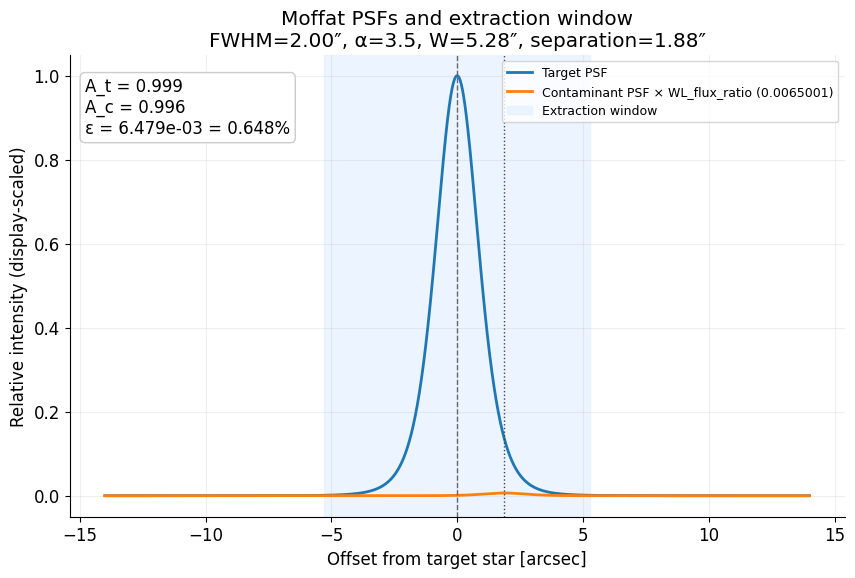

Extracted-level contamination ε = 6.479e-03 = 0.648%  (A_t=0.999, A_c=0.996)


In [402]:
d_star = 4.272                      # Pick a reference separation to read out numbers (e.g. measured d_perp) in arcseconds
d_star = d_parallel_arcsec
seeing_fwhm_arcsec = 2.0            # seeing FWHM [arcsec]
W_half_arcsec      = 5.28           # extraction half-width [arcsec]
alpha_moffat       = 3.5            # Moffat power index
band_label        = "BP"            # options: "BP", "G", "RP", # Choose which flux ratio to treat as "white-light" for this run

fG  = flux_ratio(deltaG)
fBP = flux_ratio(deltaBP)
fRP = flux_ratio(deltaRP)
flux_ratio_white  = {"BP": fBP, "G": fG, "RP": fRP}[band_label]


plot_profiles_astropy(separation_arcsec=d_star,
                      fwhm_arcsec=seeing_fwhm_arcsec,
                      W_half_arcsec=W_half_arcsec,
                      alpha=alpha_moffat,
                      flux_ratio_white=flux_ratio_white)

#### Contamination: White light results (range)
- Takes a variety of separations to give how moving the distance between the two stars makes a difference to contamination.

Flux-ratio:
   f_other / f_target = 10^(-0.4 * Δmag)

ΔG  = 5.2155 mag -> ratio = 0.008200  (~0.82 %)
ΔBP = 5.4677 mag -> ratio = 0.006500 (~0.65 %)
ΔRP = 4.9456 mag -> ratio = 0.010514 (~1.05 %)

If both sources were fully blended (no aperture losses),
the post-extraction contamination would be simply r = f_other/f_target in that band.

[BP-band, r = 0.006500]  Parameters:
  seeing FWHM = 2.00" | W_half = 5.28" | Moffat α = 3.50

At separation d = 1.88" →  A_t = 0.999, A_c = 0.996,  ε = 6.479e-03
Bias on δ_obs = 10000 ppm  →  64.79 ppm



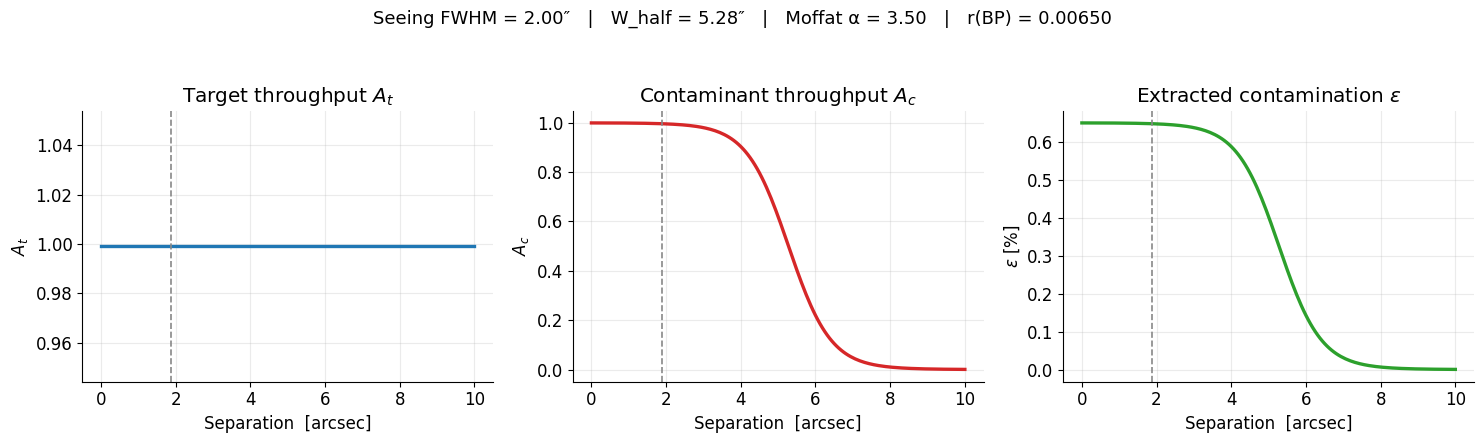

In [417]:
d_star = 4.272                      # Pick a reference separation to read out numbers (e.g. your measured d_perp)
d_star = d_parallel_arcsec
seeing_fwhm_arcsec = 2.0            # seeing FWHM [arcsec]
W_half_arcsec      = 5.28           # extraction half-width [arcsec]
alpha_moffat       = 3.5            # Moffat power index
band_label        = "BP"            # options: "BP", "G", "RP", # Choose which flux ratio to treat as "white-light" for this run
delta_obs_ppm      = 10000.0        # reference white-light transit depth (e.g., 1% = 10000 ppm)
seps = np.linspace(0.0, 10, 161)    # trace separations (arcsec) to evaluate

# Gaia flux ratios (other − target)
deltaG  = 16.9294 - 11.7139 # Gaia G-band delta mag
deltaBP = 17.4827 - 12.0150 # Gaia BP-band delta mag
deltaRP = 16.2098 - 11.2642 # Gaia RP-band delta mag
flux_ratio_white  = {"BP": fBP, "G": fG, "RP": fRP}[band_label]

def flux_ratio(delta_mag):
    """Return f_other/f_target given a magnitude difference Δmag."""
    return 10**(-0.4*delta_mag)

fG  = flux_ratio(deltaG) # Gaia G-band flux ratio
fBP = flux_ratio(deltaBP) # Gaia BP-band flux ratio
fRP = flux_ratio(deltaRP) # Gaia RP-band flux ratio

print("Flux-ratio:")
print("   f_other / f_target = 10^(-0.4 * Δmag)\n")
print(f"ΔG  = {deltaG:.4f} mag -> ratio = {fG:.6f}  (~{100*fG:.2f} %)")
print(f"ΔBP = {deltaBP:.4f} mag -> ratio = {fBP:.6f} (~{100*fBP:.2f} %)")
print(f"ΔRP = {deltaRP:.4f} mag -> ratio = {fRP:.6f} (~{100*fRP:.2f} %)")
print("\nIf both sources were fully blended (no aperture losses),")
print("the post-extraction contamination would be simply r = f_other/f_target in that band.\n")

# Evaluate A_t(d), A_c(d), epsilon(d)
eps_arr, A_t_arr, A_c_arr = [], [], []

for d in seps: # for each separation
    eps, A_t, A_c = contamination_white_light_astropy(
        separation_arcsec=d,
        fwhm_arcsec=seeing_fwhm_arcsec,
        W_half_arcsec=W_half_arcsec,
        alpha=alpha_moffat,
        flux_ratio_white=flux_ratio_white
    )
    eps_arr.append(eps)
    A_t_arr.append(A_t)
    A_c_arr.append(A_c)

eps_arr = np.array(eps_arr); A_t_arr = np.array(A_t_arr); A_c_arr = np.array(A_c_arr) # convert to arrays
ppm_bias = delta_obs_ppm * eps_arr # bias on observed transit depth in ppm

# Readout at the reference separation d_star
eps_star, A_t_star, A_c_star = contamination_white_light_astropy(
    separation_arcsec=d_star,
    fwhm_arcsec=seeing_fwhm_arcsec,
    W_half_arcsec=W_half_arcsec,
    alpha=alpha_moffat,
    flux_ratio_white=flux_ratio_white
)

print(f"[{band_label}-band, r = {flux_ratio_white:.6f}]  Parameters:")
print(f"  seeing FWHM = {seeing_fwhm_arcsec:.2f}\" | W_half = {W_half_arcsec:.2f}\" | Moffat α = {alpha_moffat:.2f}")
print(f"\nAt separation d = {d_star:.2f}\" →  A_t = {A_t_star:.3f}, A_c = {A_c_star:.3f},  ε = {eps_star:.3e}")
print(f"Bias on δ_obs = {delta_obs_ppm:.0f} ppm  →  {delta_obs_ppm*eps_star:.2f} ppm\n")

# Plot results

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 12
})

fig, axes = plt.subplots(1, 3, figsize=(15, 4.2), sharex=True)

# Left: target throughput
axes[0].plot(seps, A_t_arr, lw=2.4, color="#1f77b4")
axes[0].set_title("Target throughput $A_t$")
axes[0].set_ylabel("$A_t$")

# Middle: contaminant throughput
axes[1].plot(seps, A_c_arr, lw=2.4, color="#d62728")
axes[1].set_title("Contaminant throughput $A_c$")
axes[1].set_ylabel("$A_c$")

# Right: contamination fraction
axes[2].plot(seps, eps_arr * 100, lw=2.4, color="#2ca02c")
axes[2].set_title("Extracted contamination $\\varepsilon$")
axes[2].set_ylabel("$\\varepsilon$ [%]")

for ax in axes:
    ax.set_xlabel("Separation  [arcsec]")
    ax.axvline(d_star, color="#888888", ls="--", lw=1.2) # vertical marker at d_star

# Title summarising run configuration
su = (f"Seeing FWHM = {seeing_fwhm_arcsec:.2f}″   |   "
      f"W_half = {W_half_arcsec:.2f}″   |   "
      f"Moffat α = {alpha_moffat:.2f}   |   "
      f"r({band_label}) = {flux_ratio_white:.5f}")
fig.suptitle(su, y=1.05, fontsize=13)
fig.tight_layout()
plt.show()

#### Surface Gravity

In [410]:
logg_solar = 4.438   # solar surface gravity in cgs
M_star = 0.78 # contamination star mass in solar masses
R_star = 0.755 # contamination star radius in solar radii
logg = logg_solar + np.log(M_star) -2*np.log(R_star) # surface gravity formula
print(f"Contaminant star log(g) = {logg:.3f} (cgs)")

Contaminant star log(g) = 4.752 (cgs)


In [414]:
# --- Wavelength-binned flux ratios, Gaia-anchored, plus chromatic FWHM per bin ---

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d

# -----------------------------
# 1) Load synthetic spectra (ATLAS9)
# -----------------------------

wasp168_path = "/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/EFOSC_utils/ATLAS/ckp00_6000.fits"
starx_path   = "/Users/u2257755/Documents/Tiberius/Tiberius/src/reduction_utils/EFOSC_utils/ATLAS/ckp00_4750.fits"

syn_table_wasp_168 = fits.open(wasp168_path)[1].data
syn_table_x        = fits.open(starx_path)[1].data
syn_wvl = syn_table_x.field('WAVELENGTH')  # Wavelength grid [Å]

flux_t_raw = syn_table_wasp_168.field('g45')  # surface gravity columns (target)
flux_c_raw = syn_table_x.field('g45')         # surface gravity columns (contaminant)

# Crop to Gaia-like optical range
wl_min, wl_max = 3000.0, 11000.0
mask = (syn_wvl >= wl_min) & (syn_wvl <= wl_max)
wl = syn_wvl[mask]
Ft_raw = flux_t_raw[mask]
Fc_raw = flux_c_raw[mask]

# -----------------------------
# 2) Gaia “white-light” flux ratios from delta mag
# -----------------------------

# Gaia delta mags (other − target)
deltaG  = 16.9294 - 11.7139
deltaBP = 17.4827 - 12.0150
deltaRP = 16.2098 - 11.2642

rG  = flux_ratio(deltaG)
rBP = flux_ratio(deltaBP)
rRP = flux_ratio(deltaRP)

print("Gaia flux ratios (other/target):")
print(f"  BP: {rBP:.6f}   G: {rG:.6f}   RP: {rRP:.6f}")

# -----------------------------
# 3) Build a smooth scaling for the contaminant so that the ratio Fc/Ft hits the Gaia ratios at three anchor wavelengths.
#    Basically rescaling the contaminated spectrum to match Gaia colours.
# -----------------------------

# Raw spectral ratio on the native grid
ratio_raw = Fc_raw / Ft_raw

# Choose user-specified anchor wavelengths [Å] for BP, G, RP
lam_BP, lam_G, lam_RP = 5100.0, 6100.0, 7700.0

# --- set band ranges [Å];
band_edges = {
    "BP": (3500.0, 6600.0),
    "G":  (4000.0, 8000.0),
    "RP": (6500.0, 8500.0),
}

# Interpolate the raw ratio to those anchor points. Get a 'function' for wavelength vs. ratio
ratio_interp = interp1d(wl, ratio_raw, 
                        kind='linear', 
                        bounds_error=False,
                        fill_value=(ratio_raw[0], ratio_raw[-1])) 

raw_BP = np.mean(ratio_interp(np.arange(band_edges["BP"][0],band_edges["BP"][1],1)))
raw_G  = np.mean(ratio_interp(np.arange(band_edges["G"][0],band_edges["G"][1],1)))
raw_RP = np.mean(ratio_interp(np.arange(band_edges["RP"][0],band_edges["RP"][1],1)))

# raw_BP = float(ratio_interp(lam_BP)) # ratio value at wavelength anchor for BP
# raw_G  = float(ratio_interp(lam_G)) # ratio value at wavelength anchor for G
# raw_RP = float(ratio_interp(lam_RP)) # ratio value at wavelength anchor for RP

# Multiplicative correction needed at anchors so that scaled_ratio = Gaia ratio
# m(lam_anchor) = r_Gaia / ratio_raw(lam_anchor)
anchors_lam = np.array([lam_BP, lam_G, lam_RP]) # anchor wavelengths from before
anchors_m   = np.array([rBP / raw_BP, rG / raw_G, rRP / raw_RP]) # needed scale factors at anchors

# Piecewise-linear scale factor m(λ); flat extrapolation outside
m_interp = interp1d(anchors_lam, anchors_m, 
                    kind='linear', 
                    bounds_error=False,
                    fill_value=(anchors_m[0], anchors_m[-1]))
m_lam = m_interp(wl) # scale factor on native wavelength grid

# Scaled contaminant spectrum; scaled ratio hits Gaia at anchors
Fc_scaled = Fc_raw * m_lam
ratio_scaled = Fc_scaled / Ft_raw

# -----------------------------
# 4) Define wavelength bins (250 A) and compute per-bin flux ratios r_b
# -----------------------------
bin_width = 500  # angstroms
edges = np.arange(wl_min, wl_max + bin_width, bin_width)
centers = 0.5 * (edges[:-1] + edges[1:])

def integrate_in_bins(w, f, bin_edges):
    """Integrate f(w) over each bin using trapezoids taken from the native sampling."""
    out = np.zeros(len(bin_edges)-1, dtype=float)
    # Precompute for speed
    for i in range(len(out)):
        w1, w2 = bin_edges[i], bin_edges[i+1]
        sel = (w >= w1) & (w <= w2)
        out[i] = np.trapz(f[sel], w[sel]) # sums up all the flux in the bin
    return out

Ft_bin = integrate_in_bins(wl, Ft_raw, edges) # total target flux per bin
Fc_bin = integrate_in_bins(wl, Fc_scaled, edges) # total contaminant flux per bin
r_bin  = Fc_bin / Ft_bin  # per-bin flux ratio

# -----------------------------
# 5) Chromatic seeing FWHM per bin center
#    FWHM(λ) = FWHM0 * (λ/λ0)^(-0.2), maybe wrong?
# -----------------------------
FWHM0 = 2.5     # arcsec at λ0
lam0  = 5500.0  # Å
fwhm_bin = FWHM0 * (centers / lam0)**(-0.2)
fwhm_bin = np.array(FWHM0 * np.ones(len(centers)))  # if you want constant seeing instead


# -----------------------------
# 6) Per-bin contamination ε with chromatic seeing and constant separation
# -----------------------------

# If you want a specific reference transit depth for ppm bias:
delta_obs_ppm = 10000.0  # 1% depth; change if needed

# Compute per-bin throughputs and epsilon at fixed separation d_star
A_t_bins, A_c_bins, eps_bins = [], [], []

for i in range(len(centers)):
    # Bin center’s FWHM and flux ratio
    fwhm_here = float(fwhm_bin[i])
    r_here    = float(r_bin[i])

    # Skip empty or ill-defined bins
    if not np.isfinite(r_here) or r_here <= 0.0:
        A_t_bins.append(np.nan); A_c_bins.append(np.nan); eps_bins.append(np.nan)
        continue

    eps, A_t, A_c = contamination_white_light_astropy(
        separation_arcsec=d_star,
        fwhm_arcsec=fwhm_here,
        W_half_arcsec=W_half_arcsec,
        alpha=alpha_moffat,
        flux_ratio_white=r_here
    )
    A_t_bins.append(A_t); A_c_bins.append(A_c); eps_bins.append(eps)

A_t_bins = np.array(A_t_bins)
A_c_bins = np.array(A_c_bins)
eps_bins = np.array(eps_bins)
ppm_bins = delta_obs_ppm * eps_bins  # bias on depth in ppm

# Build a results table
bin_start = edges[:-1]
bin_end   = edges[1:]

df_bins = pd.DataFrame({
    "bin":        np.arange(len(centers)),
    "λ_start_Å":  bin_start,
    "λ_end_Å":    bin_end,
    "λ_center_Å": centers,
    "FWHM_seeing_″": fwhm_bin,
    "r = Fc/Ft":  r_bin,
    "A_t":        A_t_bins,
    "A_c":        A_c_bins,
    "ε":          eps_bins,
    "bias_ppm":   ppm_bins,
})

# Nice sorting and types
df_bins = df_bins.astype({
    "bin": int
}).reset_index(drop=True)

# Show first few rows
display(df_bins.head(25))

# Also useful summaries
print(f"Separation d* = {d_star:.3f}″, W_half = {W_half_arcsec:.2f}″, α = {alpha_moffat:.2f}")
print(f"Median ε across non-empty bins: {np.nanmedian(eps_bins):.3e}")
print(f"Max ε: {np.nanmax(eps_bins):.3e}   |   Max depth bias (ppm): {np.nanmax(ppm_bins):.1f}")



Gaia flux ratios (other/target):
  BP: 0.006500   G: 0.008200   RP: 0.010514


,bin,λ_start_Å,λ_end_Å,λ_center_Å,FWHM_seeing_″,r = Fc/Ft,A_t,A_c,ε,bias_ppm
0,0,3000.0,3500.0,3250.0,2.5,0.002084,0.997119,0.803919,0.001680,16.803232
1,1,3500.0,4000.0,3750.0,2.5,0.002790,0.997119,0.803919,0.002249,22.492221
2,2,4000.0,4500.0,4250.0,2.5,0.004520,0.997119,0.803919,0.003644,36.444976
3,3,4500.0,5000.0,4750.0,2.5,0.006563,0.997119,0.803919,0.005291,52.912399
4,4,5000.0,5500.0,5250.0,2.5,0.006735,0.997119,0.803919,0.005430,54.299810
5,5,5500.0,6000.0,5750.0,2.5,0.008346,0.997119,0.803919,0.006729,67.287156
6,6,6000.0,6500.0,6250.0,2.5,0.009008,0.997119,0.803919,0.007263,72.629308
7,7,6500.0,7000.0,6750.0,2.5,0.009785,0.997119,0.803919,0.007889,78.893175
8,8,7000.0,7500.0,7250.0,2.5,0.010220,0.997119,0.803919,0.008240,82.395642
9,9,7500.0,8000.0,7750.0,2.5,0.010831,0.997119,0.803919,0.008733,87.327196


Separation d* = 4.272″, W_half = 5.28″, α = 3.50
Median ε across non-empty bins: 8.064e-03
Max ε: 1.093e-02   |   Max depth bias (ppm): 109.3


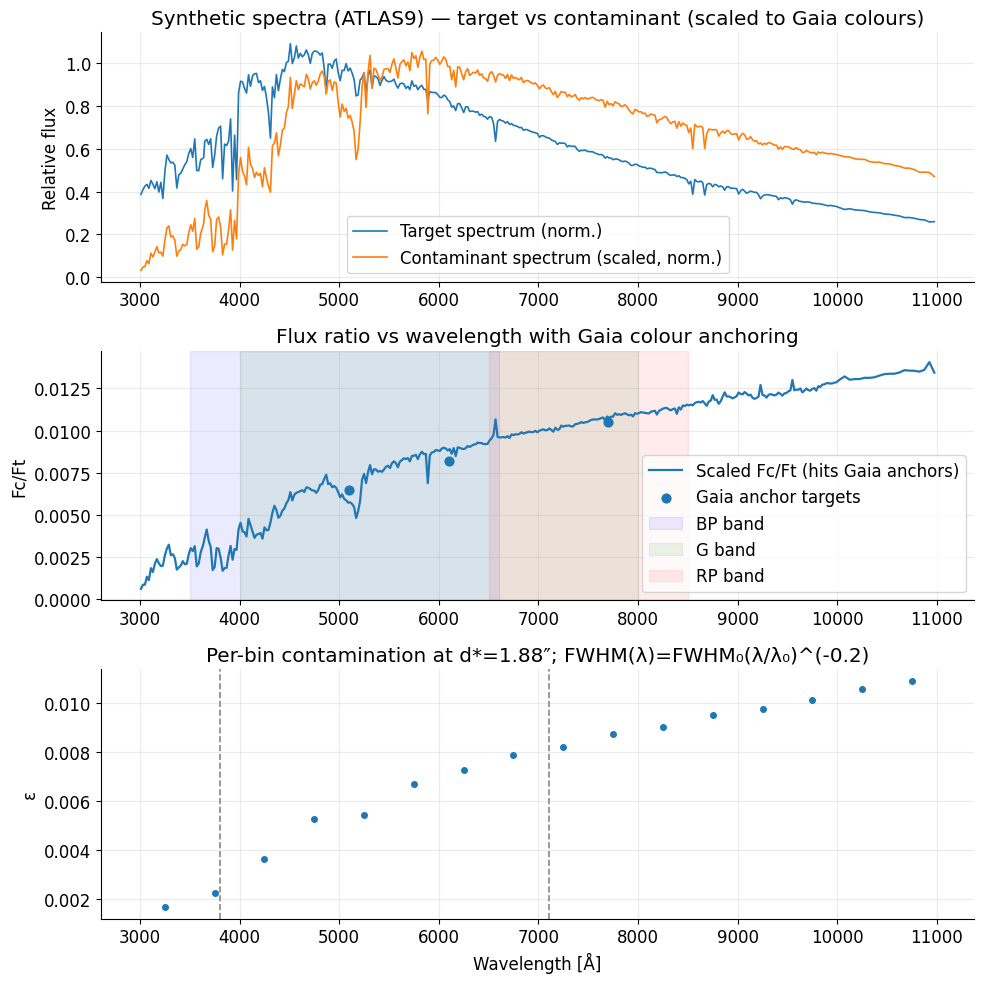

In [429]:
# --- Plots for sanity checks: spectra overlay, Fc/Ft with anchors, ε per bin ---

import matplotlib.pyplot as plt

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 12
})

fig = plt.figure(figsize=(10, 10))

# 1) Spectra overlay (normalized)
ax1 = fig.add_subplot(3,1,1)
# robust normalisation to 95th percentile to avoid line cores dominating
def robust_norm(x):
    p = np.nanpercentile(x, 95.0)
    return x / (p if p > 0 else 1.0)

ax1.plot(wl, robust_norm(Ft_raw), lw=1.2, label="Target spectrum (norm.)")
ax1.plot(wl, robust_norm(Fc_scaled), lw=1.2, label="Contaminant spectrum (scaled, norm.)")

ax1.set_ylabel("Relative flux")
ax1.set_title("Synthetic spectra (ATLAS9) — target vs contaminant (scaled to Gaia colours)")
ax1.legend(loc="best")

# 2) Flux ratio Fc/Ft with raw vs Gaia-anchored scaled curve and anchor markers
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ratio_raw = Fc_raw / np.maximum(Ft_raw, 1e-300)
ratio_scaled = Fc_scaled / np.maximum(Ft_raw, 1e-300)
#ax2.plot(wl, ratio_raw,    lw=1.0, label="Raw Fc/Ft")
ax2.plot(wl, ratio_scaled, lw=1.6, label="Scaled Fc/Ft (hits Gaia anchors)")

# Anchor wavelengths and Gaia ratios used earlier
lam_BP, lam_G, lam_RP = 5100.0, 6100.0, 7700.0
ax2.scatter([lam_BP, lam_G, lam_RP], [rBP, rG, rRP], zorder=3, s=40, marker="o",
            label="Gaia anchor targets")

# Visual band spans (Gaia-like) with colours
band_edges = {
    "BP": (3500.0, 6600.0),
    "G":  (4000.0, 8000.0),
    "RP": (6500.0, 8500.0)
}
band_colors = {"BP": "blue", "G": "green", "RP": "red"}

for name, (a, b) in band_edges.items():
    ax2.axvspan(a, b, color=band_colors[name], alpha=0.08, label=f"{name} band")

ax2.set_ylabel("Fc/Ft")
ax2.set_title("Flux ratio vs wavelength with Gaia colour anchoring")
ax2.legend(loc="best")

# 3) ε per bin (points at bin centers), and show A_t and A_c as thin lines on secondary y-axis
ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.axvline([3800], color="#888888", ls="--", lw=1.2) # vertical marker at wavelength of interest
ax3.axvline([7110], color="#888888", ls="--", lw=1.2) # vertical marker at wavelength of interest

ax3.plot(centers, eps_bins, lw=0, marker="o", ms=4, label="ε per 250 Å bin")
ax3.set_ylabel("ε")
ax3.set_xlabel("Wavelength [Å]")
ax3.set_title(f"Per-bin contamination at d*={d_star:.2f}″; FWHM(λ)=FWHM₀(λ/λ₀)^(-0.2)")

# Combined legend
h1, l1 = ax3.get_legend_handles_labels()
h2, l2 = ax3b.get_legend_handles_labels()
ax3b.legend(h1+h2, l1+l2, loc="best")

plt.tight_layout()
plt.show()

#### 1) White-light: target only vs target+contaminant

Input true depth:          10000.0 ppm
Observed depth w/o contam: 10000.0 ppm
Observed depth with contam:9940.4 ppm
Theory δ_true/(1+ε):       9940.4 ppm
Difference of δ_true and δ_obs: 59.6 ppm
Recover δ_true from δ_obs: δ_true = δ_obs*(1+ε)


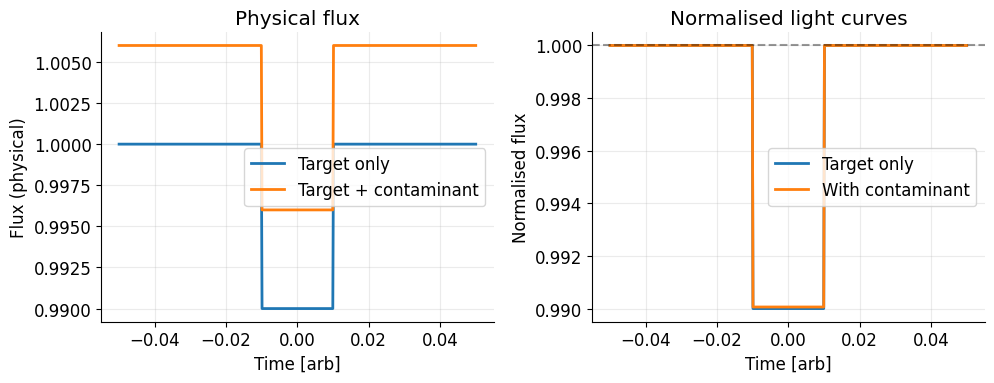

In [ ]:
def demo_white_light(delta_true_ppm=1000.0, epsilon=0.05):
   
    delta_true = delta_true_ppm * 1e-6   # convert ppm -> fraction

    # Simple box transit
    t = np.linspace(-0.05, 0.05, 500)
    in_tr = np.abs(t) < 0.01

    Ft = 1.0                  # target baseline
    Fc = epsilon * Ft         # contaminant baseline

    # True flux, no contaminant (physical units)
    F_true = Ft * np.ones_like(t)
    F_true[in_tr] = Ft * (1 - delta_true)

    # With contaminant (physical units)
    F_with = F_true + Fc
    F_out_with = Ft + Fc

    # Normalise as we do in real light curves
    F_true_norm = F_true / Ft
    F_with_norm = F_with / F_out_with

    # Measured depths
    depth_true_meas  = 1 - F_true_norm[in_tr].mean()
    depth_with_meas  = 1 - F_with_norm[in_tr].mean()
    depth_theory     = delta_true / (1 + epsilon)
    delta_depth = depth_true_meas - depth_with_meas

    print(f"Input true depth:          {delta_true_ppm:.1f} ppm")
    print(f"Observed depth w/o contam: {depth_true_meas*1e6:.1f} ppm")
    print(f"Observed depth with contam:{depth_with_meas*1e6:.1f} ppm")
    print(f"Theory δ_true/(1+ε):       {depth_theory*1e6:.1f} ppm")
    print(f"Difference of δ_true and δ_obs: {delta_depth*1e6:.1f} ppm")

    print(f"Recover δ_true from δ_obs: δ_true = δ_obs*(1+ε)")

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True)

    # Physical flux
    axes[0].plot(t, F_true, label="Target only", lw=2)
    axes[0].plot(t, F_with, label="Target + contaminant", lw=2)
    axes[0].set_xlabel("Time [arb]")
    axes[0].set_ylabel("Flux (physical)")
    axes[0].set_title("Physical flux")
    axes[0].legend()

    # Normalised
    axes[1].plot(t, F_true_norm, label="Target only", lw=2)
    axes[1].plot(t, F_with_norm, label="With contaminant", lw=2)
    axes[1].axhline(1.0, color="k", ls="--", alpha=0.4)
    axes[1].set_xlabel("Time [arb]")
    axes[1].set_ylabel("Normalised flux")
    axes[1].set_title("Normalised light curves")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Example call:
demo_white_light(delta_true_ppm=10000.0, epsilon=0.006)

#### 2) Correct an array of k(λ) using ε(λ) from df_bins

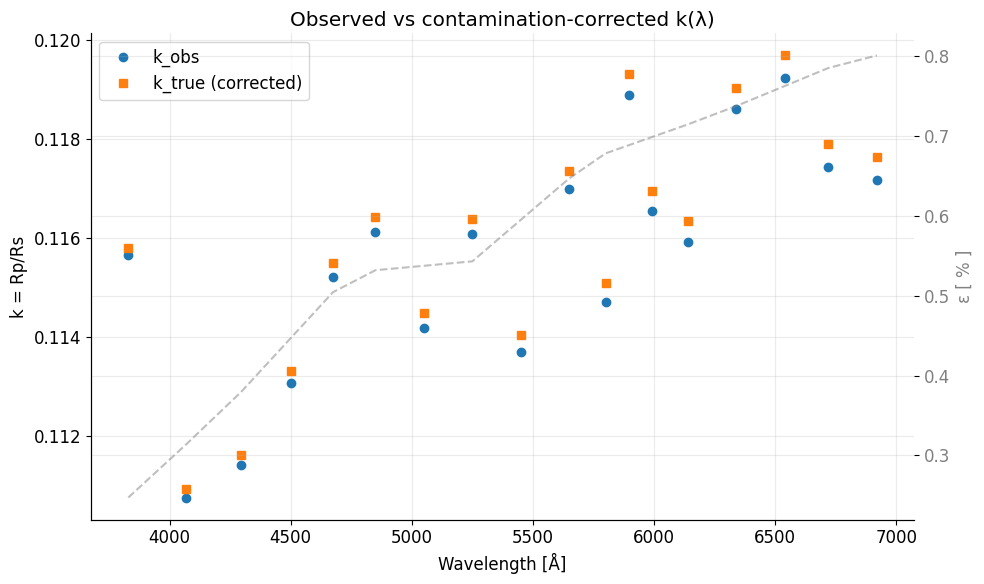

In [ ]:
def correct_k_spectrum(wavelengths_A, k_obs, df_bins):
    """
    Parameters
    ----------
    wavelengths_A : 1D array wavelengths [angstroms] at which k_obs is defined.
    k_obs : 1D array observed radius ratios at those wavelengths.
    df_bins : DataFrame must contain columns 'λ_center_Å' and 'ε'.

    Returns
    -------
    k_true : 1D array contamination-corrected radius ratios.
    eps_at_k : 1D array epsilon(lambda) values used for the correction.
    """

    lam_eps = df_bins["λ_center_Å"].values
    eps_vals = df_bins["ε"].values

    # Interpolate ε(λ) onto k’s wavelength grid
    eps_interp = interp1d(
        lam_eps, eps_vals,
        kind="linear",
        bounds_error=False,
        fill_value=(eps_vals[0], eps_vals[-1])
    )
    eps_at_k = eps_interp(wavelengths_A)

    # Apply k_true = k_obs * sqrt(1 + epsilon)
    k_true = k_obs * np.sqrt(1.0 + eps_at_k)

    return k_true, eps_at_k

def plot_k_correction(wavelengths_A, k_obs, k_true, eps_at_k):
    """
    Plot observed vs corrected k, and ε on a secondary axis.
    """
    fig, ax1 = plt.subplots(figsize=(10,6))

    ax1.plot(wavelengths_A, k_obs,  marker="o", lw=0, label="k_obs")
    ax1.plot(wavelengths_A, k_true, marker="s", lw=0, label="k_true (corrected)")
    ax1.set_xlabel("Wavelength [Å]")
    ax1.set_ylabel("k = Rp/Rs")
    ax1.set_title("Observed vs contamination-corrected k(λ)")
    ax1.legend(loc="upper left")

    # epsilon(lambda) as percentage on right axis
    ax2 = ax1.twinx()
    ax2.plot(wavelengths_A, 100*eps_at_k, color="grey", ls="--", alpha=0.5)
    ax2.set_ylabel("ε [ % ]", color="grey")
    ax2.tick_params(axis="y", labelcolor="grey")

    plt.tight_layout()
    plt.show()


lam_k = np.array([
    3830.0, 4070.0, 4295.0, 4500.0, 4675.0, 4850.0, 5050.0, 5250.0, 5450.0,
    5650.0, 5800.0, 5895.0, 5990.0, 6140.0, 6340.0, 6540.0, 6720.0, 6920.0
])
k_obs = np.array([
    0.115649, 0.110745, 0.111396, 0.113059, 0.115212, 0.116123, 0.114174,
    0.116080, 0.113700, 0.116989, 0.114705, 0.118903, 0.116544, 0.115927,
    0.118605, 0.119243, 0.117438, 0.117178
])
k_true, eps_at_k = correct_k_spectrum(lam_k, k_obs, df_bins)
plot_k_correction(lam_k, k_obs, k_true, eps_at_k)